# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id  ...                                               Text
1146    1245  ...  This was a really good idea and the final prod...
1145    1244  ...  I just received my shipment and could hardly w...
28086  30629  ...  Nothing against the product, but it does bothe...
28087  30630  ...  I love this stuff. It is sugar-free so it does...
38740  42069  ...  Fresh limes are underappreciated, but a joy to...

[5 rows x 10 columns]


In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:14<00:00, 3152.49it/s]


In [19]:
preprocessed_reviews[1500]

'orange lemon peels make tea hippy despite initial oohing ahing pretty blue flowers regrettable purchase hoping stronger bergamot component twinings earl grey instead got something seems herbal blech disagree positive reviews'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.4.1] loading tfidf and w2v pickles


In [0]:


import pickle 
import os

# dbfile1 = open('/content/drive/My Drive/FFRDB/tfidf.pkl', 'wb')
# pickle.dump(tfidf_sent_vectors, dbfile1)                      
# dbfile1.close()
dbfile1 = open('/content/drive/My Drive/FFRDB/tfidf_50k.pkl', 'rb')  
tfidf_sent_vectors = pickle.load(dbfile1)  


# dbfile2 = open('/content/drive/My Drive/FFRDB/sent_vectors.pkl', 'wb')
# pickle.dump(sent_vectors, dbfile2)                      
# dbfile.close()
dbfile2 = open('/content/drive/My Drive/FFRDB/sent_vectors_50k.pkl', 'rb') 
sent_vectors= pickle.load(dbfile2)

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

## [5.1.1.1] Applying KNN brute force on BOW wihth k ranging till 10k,<font color='red'> SET 1</font>

In [0]:
#generating random alpha values between 10 to 10^4
from numpy import random 
n=list()
n.extend([random.randint(0, 100) for iter in range(9)])
n.extend([random.randint(100, 1000) for iter in range(7)])
n.extend([random.randint(1000, 5000) for iter in range(12)])
n.extend([random.randint(5000, 8000) for iter in range(17)])

n.sort()


with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'ab') as fr:
    for i in n:
      pickle.dump(i,fr)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)


print('\n\n')

print(n)
print(len(n))

(32249, 5000)
(13822, 5000)



[5, 7, 25, 39, 40, 66, 74, 76, 91, 155, 179, 285, 335, 572, 596, 761, 1760, 2001, 2078, 2449, 2538, 3369, 3776, 4011, 4396, 4468, 4925, 4948, 5133, 5273, 5290, 5612, 5659, 5993, 6213, 6430, 6863, 7093, 7115, 7138, 7346, 7512, 7529, 7614, 7624]
45


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=0
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [5, 7, 25, 39, 40, 66, 74, 76, 91, 155]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.4min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=10
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': [179, 285, 335, 572, 596, 761, 1760, 2001, 2078, 2449]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.4min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=20
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': [2538, 3369, 3776, 4011, 4396, 4468, 4925, 4948, 5133, 5273]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 23.3min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=30
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [5290, 5612, 5659, 5993, 6213, 6430, 6863, 7093, 7115, 7138]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.9min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=40
n_temp=n[i:i+5]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [7346, 7512, 7529, 7614, 7624]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.6min finished


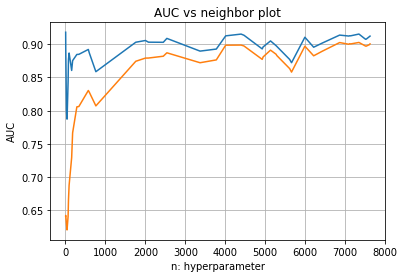

In [0]:

train_auc = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'rb') as fr:
    try:
        while True:
            train_auc.append(pickle.load(fr))
    except EOFError:
        pass
cv_auc = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'rb') as fr:
    try:
        while True:
            cv_auc.append(pickle.load(fr))
    except EOFError:
        pass

n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass
plt.plot(n,train_auc,label='Train AUC')
plt.plot(n, cv_auc,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n: hyperparameter")
plt.ylabel("AUC")
plt.show()
plt.clf()
plt.cla()
plt.close()



In [0]:
#usnig n values less than 7500 as above that the colab crashes. But also prior approches revealed that 
#best n values lies with in 6000 to 8000 range so sticking with 6863 and ignoring the last 11 values of n
#which were greater than 8000



#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')



best cv score to use = 0.902575098838714
best n neighbor to use = 6863


In [0]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=6863,n_jobs=-1)
knn.fit(X_train,y_train)
y_pred_tr = knn.predict_proba(X_train)
y_pred_ts = knn.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]



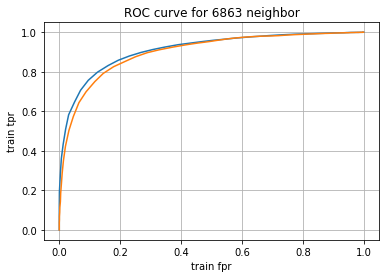

In [0]:


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (6863)+' neighbor')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.6981355843804085 for threshold 0.877
****************************************************************************************************
Train Confusion Matrix


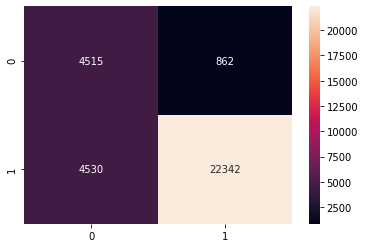

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Test Confusion Matrix


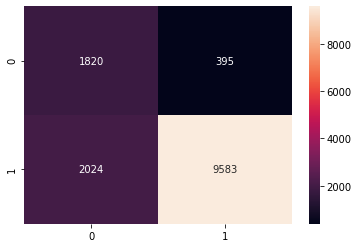

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:


acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 82.50%
Precision on test set: 96.04%
recall score on test set: 82.56%
f1 score on test set: 88.79%


## [5.1.1.2] Applying KNN brute force on BOW wihth k ranging till 100,<font color='red'> SET 1</font>


In [0]:
n=[]
n=np.arange(3,100,2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)



(32249, 5000)
(13822, 5000)


In [0]:
param = {'n_neighbors':n}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 45.6min finished


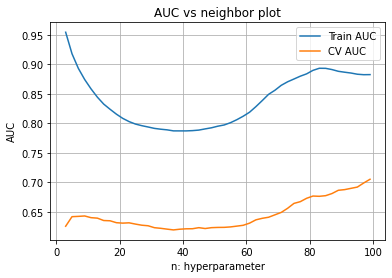

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(n,train_auc,label='Train AUC')
plt.plot(n,cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n: hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()


In [0]:

#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

print(local_diff)
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')

[0.23139419202930545, 0.17168854123252675, 0.16550109522428735, 0.21317911821075752]
best cv score to use = 0.6231574510656914
best n neighbor to use = 45


In [0]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=best_n,n_jobs=-1)
knn.fit(X_train,y_train)
y_pred_tr = knn.predict_proba(X_train)
y_pred_ts = knn.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]



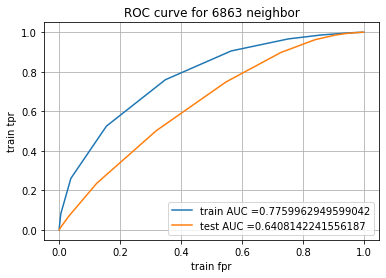

In [0]:


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (6863)+' neighbor')
plt.legend()
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.4950050502888959 for threshold 0.911
****************************************************************************************************
Train Confusion Matrix


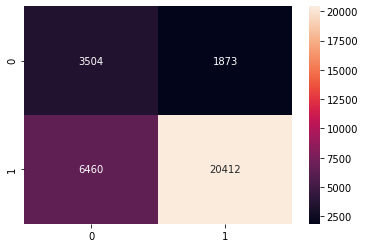

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Test Confusion Matrix


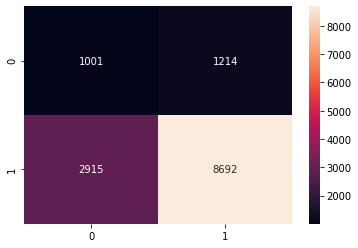

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:


acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 70.13%
Precision on test set: 87.74%
recall score on test set: 74.89%
f1 score on test set: 80.81%


The trend shows that k found in the range 6k to 10k is better than one found in range below 1k as the precision score is better for an unbalanced dataset along with the ROC AUC socre. 

### [5.1.2.1] Applying KNN brute force on TFIDF with k ranging till 10k,<font color='red'> SET 2</font>

In [0]:
#generating random alpha values between 10 to 10^4
from numpy import random 
n=list()
n.extend([random.randint(0, 100) for iter in range(9)])
n.extend([random.randint(100, 1000) for iter in range(9)])
n.extend([random.randint(1000, 5000) for iter in range(12)])
n.extend([random.randint(5000, 8000) for iter in range(18)])
n.extend([random.randint(8500, 10000) for iter in range(7)])


n.sort()


with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'ab') as fr:
    for i in n:
      pickle.dump(i,fr)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)


print('\n\n')

print(n)
print(len(n))

(32249, 5000)
(13822, 5000)



[1, 7, 22, 26, 47, 48, 60, 61, 75, 187, 199, 207, 256, 351, 433, 604, 800, 870, 1369, 1898, 2229, 2376, 2790, 3261, 3512, 3767, 3854, 4361, 4574, 4626, 5142, 5264, 5392, 5419, 5758, 5936, 6077, 6122, 6415, 6529, 6557, 6650, 6687, 6740, 7440, 7470, 7506, 7657, 8521, 8656, 8671, 9291, 9457, 9860, 9989]
55


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=0
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [1, 7, 22, 26, 47, 48, 60, 61, 75, 187]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.4min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=10
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [199, 207, 256, 351, 433, 604, 800, 870, 1369, 1898]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.9min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=20
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [2229, 2376, 2790, 3261, 3512, 3767, 3854, 4361, 4574, 4626]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.2min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=30
n_temp=n[i:i+10]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': [5142, 5264, 5392, 5419, 5758, 5936, 6077, 6122, 6415, 6529]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.7min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=40
n_temp=n[i:i+5]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [6557, 6650, 6687, 6740, 7440]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 20.7min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=45
n_temp=n[i:i+5]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [7470, 7506, 7657, 8521, 8656]}
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 25.9min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=50
n_temp=n[i:i+1]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [8671]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=8671 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=8671, score=(train=0.930, test=0.924), total=  21.7s
[CV] n_neighbors=8671 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  n_neighbors=8671, score=(train=0.930, test=0.936), total=  18.9s
[CV] n_neighbors=8671 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV]  n_neighbors=8671, score=(train=0.931, test=0.925), total=  20.4s
[CV] n_neighbors=8671 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV]  n_neighbors=8671, score=(train=0.932, test=0.921), total=  20.4s
[CV] n_neighbors=8671 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.5min remaining:    0.0s


[CV]  n_neighbors=8671, score=(train=0.931, test=0.930), total=  20.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.3min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=51
n_temp=n[i:i+1]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [9291]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=9291 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=9291, score=(train=0.923, test=0.921), total=  29.2s
[CV] n_neighbors=9291 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV]  n_neighbors=9291, score=(train=0.917, test=0.921), total=  21.0s
[CV] n_neighbors=9291 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV]  n_neighbors=9291, score=(train=0.924, test=0.918), total=  23.5s
[CV] n_neighbors=9291 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV]  n_neighbors=9291, score=(train=0.924, test=0.912), total=  21.5s
[CV] n_neighbors=9291 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.5min remaining:    0.0s


[CV]  n_neighbors=9291, score=(train=0.926, test=0.922), total=  21.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=52
n_temp=n[i:i+1]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [9457]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=9457 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=9457, score=(train=0.924, test=0.920), total=  21.9s
[CV] n_neighbors=9457 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  n_neighbors=9457, score=(train=0.917, test=0.921), total=  21.6s
[CV] n_neighbors=9457 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV]  n_neighbors=9457, score=(train=0.925, test=0.920), total=  22.2s
[CV] n_neighbors=9457 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.4min remaining:    0.0s


[CV]  n_neighbors=9457, score=(train=0.927, test=0.915), total=  22.1s
[CV] n_neighbors=9457 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.3min remaining:    0.0s


[CV]  n_neighbors=9457, score=(train=0.927, test=0.924), total=  22.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.1min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=53
n_temp=n[i:i+1]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [9860]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=9860 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=9860, score=(train=0.926, test=0.921), total=  22.4s
[CV] n_neighbors=9860 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  n_neighbors=9860, score=(train=0.919, test=0.923), total=  22.5s
[CV] n_neighbors=9860 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV]  n_neighbors=9860, score=(train=0.923, test=0.919), total=  22.6s
[CV] n_neighbors=9860 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV]  n_neighbors=9860, score=(train=0.927, test=0.917), total=  22.5s
[CV] n_neighbors=9860 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[CV]  n_neighbors=9860, score=(train=0.925, test=0.923), total=  22.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min finished


In [0]:
n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

i=54
n_temp=n[i:i+1]
knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n_temp}
print(param)
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)



with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_train_score']):
      pickle.dump(i,fr)

with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'ab') as fr:
    for i in list(temp_gs['mean_test_score']):
      pickle.dump(i,fr)

{'n_neighbors': [9989]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=9989 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=9989, score=(train=0.921, test=0.917), total=  22.9s
[CV] n_neighbors=9989 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  n_neighbors=9989, score=(train=0.915, test=0.920), total=  22.4s
[CV] n_neighbors=9989 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV]  n_neighbors=9989, score=(train=0.920, test=0.914), total=  23.0s
[CV] n_neighbors=9989 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV]  n_neighbors=9989, score=(train=0.922, test=0.910), total=  23.1s
[CV] n_neighbors=9989 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.7min remaining:    0.0s


[CV]  n_neighbors=9989, score=(train=0.922, test=0.921), total=  23.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.6min finished


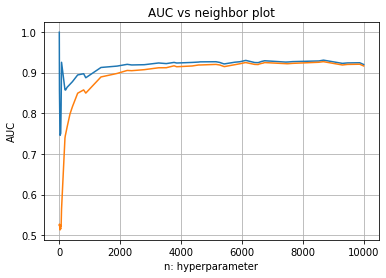

In [0]:

train_auc = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/train_auc.pkl', 'rb') as fr:
    try:
        while True:
            train_auc.append(pickle.load(fr))
    except EOFError:
        pass
cv_auc = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/cv_auc.pkl', 'rb') as fr:
    try:
        while True:
            cv_auc.append(pickle.load(fr))
    except EOFError:
        pass

n = []
with open('/content/drive/My Drive/Classroom/assignments/AFFR KNN/n.pkl', 'rb') as fr:
    try:
        while True:
            n.append(pickle.load(fr))
    except EOFError:
        pass

plt.plot(n,train_auc,label='Train AUC')
plt.plot(n, cv_auc,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n: hyperparameter")
plt.ylabel("AUC")
plt.show()
plt.clf()
plt.cla()
plt.close()



In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.9207178525358748
best n neighbor to use = 9860


In [0]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=best_n,n_jobs=-1)
knn.fit(X_train,y_train)
y_pred_tr = knn.predict_proba(X_train)
y_pred_ts = knn.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]



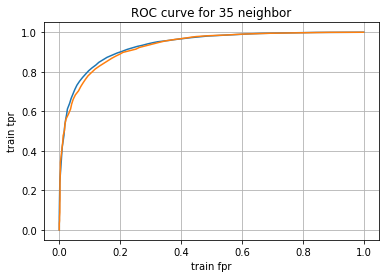

In [0]:

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.7376130750631334 for threshold 0.874
****************************************************************************************************
Train Confusion Matrix


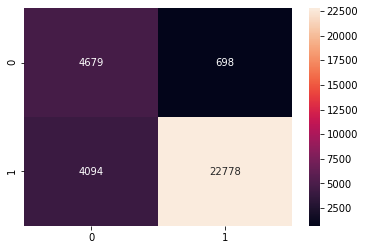

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Test Confusion Matrix


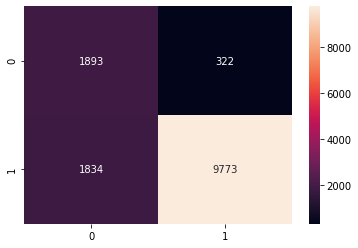

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:


acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 84.40%
Precision on test set: 96.81%
recall score on test set: 84.20%
f1 score on test set: 90.07%


### [5.1.2.2] Applying KNN brute force on tfidf wihth k ranging till 100,<font color='red'> SET 2</font>


In [0]:
n=[]
n=np.arange(3,100,2)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)


(32249, 5000)
(13822, 5000)


In [0]:
param = {'n_neighbors':n}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])}
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 47.4min finished


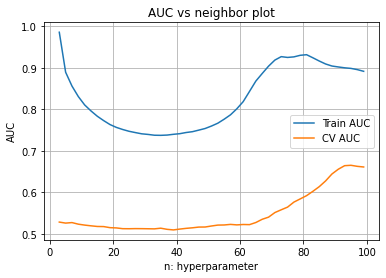

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc=temp_gs['mean_test_score']

plt.plot(n,train_auc,label='Train AUC')
plt.plot(n, cv_auc,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n: hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()


In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.5139793847168118
best n neighbor to use = 35


In [0]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=best_n,n_jobs=-1)
knn.fit(X_train,y_train)
y_pred_tr = knn.predict_proba(X_train)
y_pred_ts = knn.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]



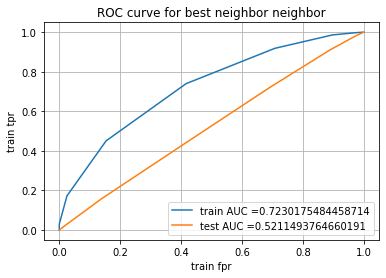

In [0]:


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for best neighbor neighbor')
plt.legend()
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.43167450919901146 for threshold 0.914
****************************************************************************************************
Train Confusion Matrix


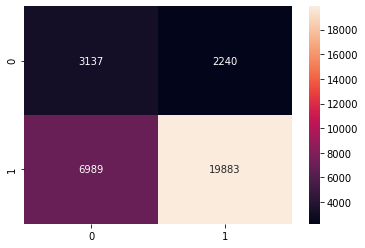

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Train Confusion Matrix


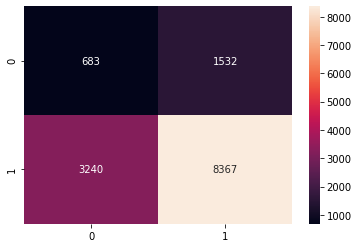

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


In [0]:


acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 65.48%
Precision on test set: 84.52%
recall score on test set: 72.09%
f1 score on test set: 77.81%


### [5.1.3.1] Applying KNN brute force on AVG   W2V wihth k ranging till 100,<font color='red'> SET 3</font>


In [0]:
import numpy as np 
n=list()

n=list(np.arange(3,100,2))

In [0]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(np.array(sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train_avg)
X_test = ss.transform(X_test_avg)

y_train,y_test=y_train_avg, y_test_avg

print(X_train.shape)
print(X_test.shape)

print('\n\n')
print(n)
print(len(n))

(32249, 50)
(13822, 50)



[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
49


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_jobs=-1)
param = {'n_neighbors':n}

temp_gscv= GridSearchCV(knn,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 63.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 160.7min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 257.0min finished


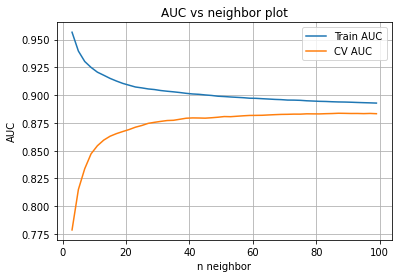

In [0]:
train_auc=temp_gs['mean_train_score']
cv_auc=temp_gs['mean_test_score']

plt.plot(n,train_auc,label='Train AUC')
plt.plot(n, cv_auc,label='CV AUC')

plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n neighbor")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()



In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.8835122696548309
best n neighbor to use = 97


In [0]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

knn = KNeighborsClassifier(n_neighbors=best_n,n_jobs=-1)
knn.fit(X_train,y_train)
y_pred_tr = knn.predict_proba(X_train)
y_pred_ts = knn.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]



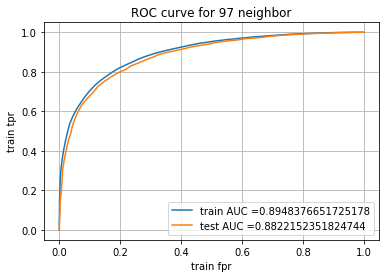

In [0]:

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.grid()
plt.legend()
plt.show()

the maximum value of tpr*(1-fpr) 0.659287490415303 for threshold 0.804
****************************************************************************************************
Train Confusion Matrix


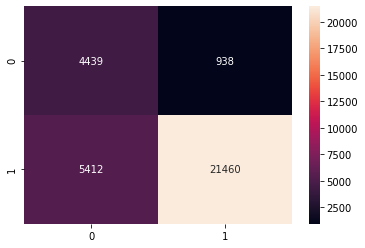

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Train Confusion Matrix


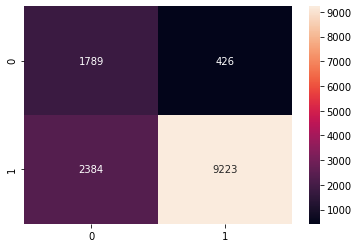

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 79.67%
Precision on test set: 95.59%
recall score on test set: 79.46%
f1 score on test set: 86.78%


### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
n=list(np.arange(3,100,2))

In [0]:
X_train_tw, X_test_tw, y_train_tw, y_test_tw = train_test_split(np.array(tfidf_sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_tw = ss.fit_transform(X_train_tw)
X_test_tw = ss.transform(X_test_tw)

print(X_train_tw.shape)
print(X_test_tw.shape)


print('\n\n')
print(n)
print(len(n))

(32249, 50)
(13822, 50)



[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
49


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_jobs=-1)

param = {'n_neighbors':n}
gs = GridSearchCV(knn,param,cv=5,verbose=15,scoring='roc_auc',n_jobs=-1,return_train_score=True)

gs.fit(X_train_tw,y_train_tw)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 12

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51, 53, 55, 57, 59, 61, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=15)

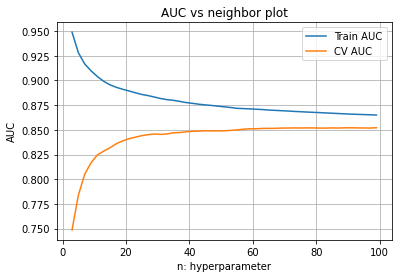

In [0]:
train_auc = gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

plt.plot(n,train_auc,label='Train AUC')
plt.plot(n, cv_auc,label='CV AUC')

plt.grid()
plt.title('AUC vs neighbor plot')
plt.xlabel("n: hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.close()



In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.8520789294235463
best n neighbor to use = 91


In [0]:
knn = KNeighborsClassifier(n_neighbors=best_n, n_jobs=-1)
knn.fit(X_train_tw,y_train_tw)
y_pred_tw = knn.predict_proba(X_test_tw)
y_pred_tr = knn.predict_proba(X_train_tw)


y_pred_ts=y_pred_tw[:,1]
y_pred_tr = y_pred_tr[:,1]

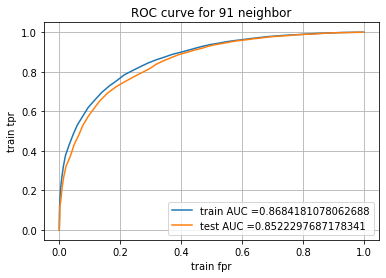

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_tw, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_tw, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.legend()
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.6169749530807316 for threshold 0.813
****************************************************************************************************
Train Confusion Matrix


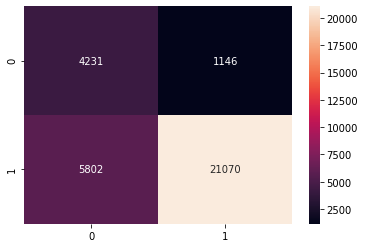

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_tw, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Train Confusion Matrix


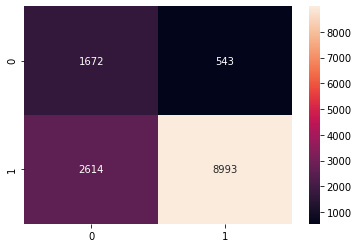

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test_tw, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


In [0]:
acc=accuracy_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))


Accuracy on test set: 77.16%
Precision on test set: 94.31%
recall score on test set: 77.48%
f1 score on test set: 85.07%


## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

---




In [0]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(min_df=10 , max_features=500)
vectorizer.fit(X_train_bow) 
X_train_bow = vectorizer.transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

ss = StandardScaler(with_mean = False)
X_train_bow = ss.fit_transform(X_train_bow)
X_test_bow = ss.transform(X_test_bow)

print(X_train_bow.shape)
print(X_test_bow.shape)

(32249, 500)
(13822, 500)


In [0]:
knn = KNeighborsClassifier(algorithm='kd_tree')

param = {'n_neighbors':np.arange(3,100,2)}
gs= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs.fit(X_train_bow,y_train_bow)


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 47.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

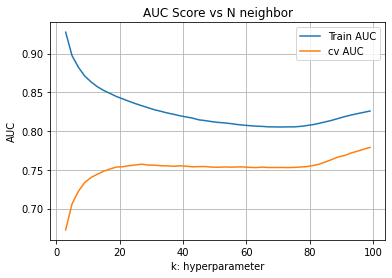

In [0]:
train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

plt.plot(param['n_neighbors'],train_auc,label='Train AUC')
plt.plot(param['n_neighbors'], cv_auc,label='cv AUC')
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title('AUC Score vs N neighbor')
plt.grid()
plt.legend()
plt.show()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.7530766438698288
best n neighbor to use = 71


In [0]:
knn = KNeighborsClassifier(n_neighbors=71, algorithm ='kd_tree', n_jobs=-1)
knn.fit(X_train_bow,y_train_bow)
y_pred_bow = knn.predict_proba(X_test_bow)
y_pred_tr = knn.predict_proba(X_train_bow)
y_pred_ts=y_pred_bow[:,1]
y_pred_tr = y_pred_tr[:,1]


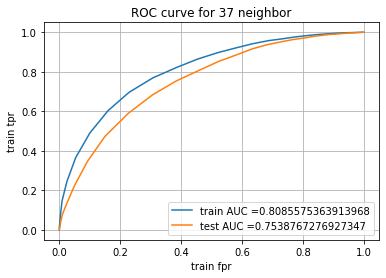

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_bow, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_bow, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.legend()
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.5365026911343194 for threshold 0.859
****************************************************************************************************
Train Confusion Matrix


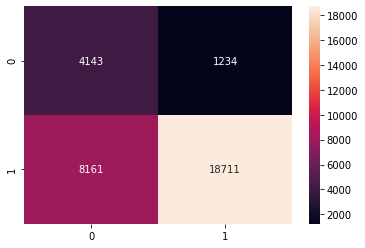

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)


print('*'*100)


print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_bow, predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')


Train Confusion Matrix


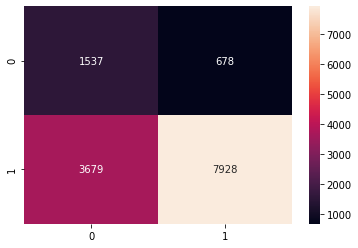

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test_bow, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test_bow, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test_bow, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test_bow, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test_bow, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 68.48%
Precision on test set: 92.12%
recall score on test set: 68.30%
f1 score on test set: 78.44%


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 , max_features=500)
tf_idf_vect.fit(X_train_tf)

X_train_tf = tf_idf_vect.transform(X_train_tf)
X_test_tf = tf_idf_vect.transform(X_test_tf)

ss = StandardScaler(with_mean = False)
X_train_tf = ss.fit_transform(X_train_tf)
X_test_tf = ss.transform(X_test_tf)

print(X_train_tf.shape)
print(X_test_tf.shape)

(32249, 500)
(13822, 500)


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=1)

param = {'n_neighbors':np.arange(3,100,2)}
gs= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs.fit(X_train_tf,y_train_tf)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 45.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

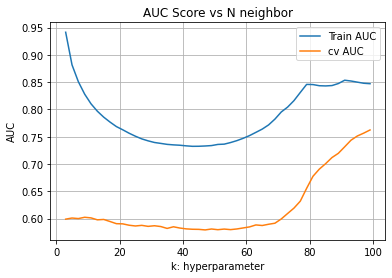

In [0]:
train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

plt.plot(param['n_neighbors'],train_auc,label='Train AUC')
plt.plot(param['n_neighbors'], cv_auc,label='cv AUC')
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title('AUC Score vs N neighbor')
plt.grid()
plt.legend()
plt.show()



In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.
n=param['n_neighbors']
from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')



best cv score to use = 0.5850621342172255
best n neighbor to use = 37


In [0]:
knn = KNeighborsClassifier(n_neighbors=best_n, algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train_tf,y_train_tf)
y_pred_tf = knn.predict_proba(X_test_tf)
y_pred_tr = knn.predict_proba(X_train_tf)
y_pred_ts=y_pred_tf[:,1]
y_pred_tr = y_pred_tr[:,1]

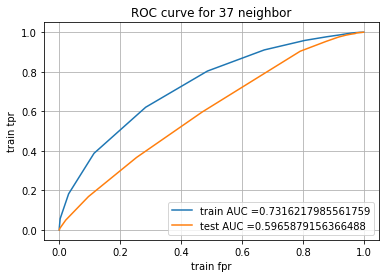

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_tf, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_tf, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.legend()
plt.grid()
plt.show()


In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.4444525249312856 for threshold 0.892


Train Confusion Matrix


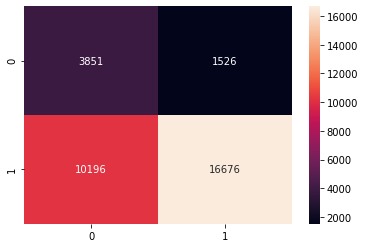

In [0]:
print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_tf ,predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')



Train Confusion Matrix


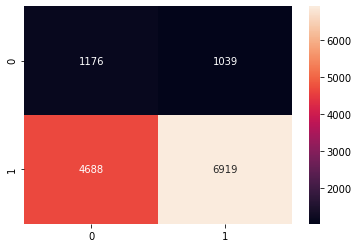

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test_tf, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test_tf, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test_tf, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test_tf, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test_tf, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 58.57%
Precision on test set: 86.94%
recall score on test set: 59.61%
f1 score on test set: 70.73%


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

In [0]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(np.array(sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_avg = ss.fit_transform(X_train_avg)
X_test_avg = ss.transform(X_test_avg)

print(X_train_avg.shape)
print(X_test_avg.shape)

(32249, 50)
(13822, 50)


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=1)

param = {'n_neighbors':np.arange(3,100,2)}
gs= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs.fit(X_train_avg,y_train_avg)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 161.7min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 259.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

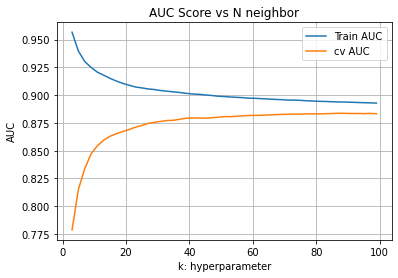

In [0]:
train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

plt.plot(param['n_neighbors'],train_auc,label='Train AUC')
plt.plot(param['n_neighbors'], cv_auc,label='cv AUC')
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title('AUC Score vs N neighbor')
plt.grid()
plt.legend()
plt.show()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.
n=param['n_neighbors']
from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')


best cv score to use = 0.8835122696548309
best n neighbor to use = 97


In [0]:
knn = KNeighborsClassifier(n_neighbors=best_n, algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train_avg,y_train_avg)
y_pred_avg = knn.predict_proba(X_test_avg)
y_pred_tr = knn.predict_proba(X_train_avg)
y_pred_ts=y_pred_avg[:,1]
y_pred_tr = y_pred_tr[:,1]

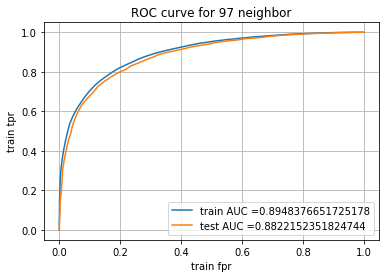

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_avg, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_avg, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.legend()
plt.grid()
plt.show()


In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.659287490415303 for threshold 0.804


Train Confusion Matrix


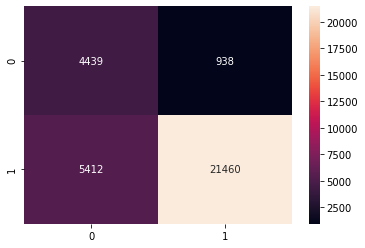

In [0]:
print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_avg ,predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

Train Confusion Matrix


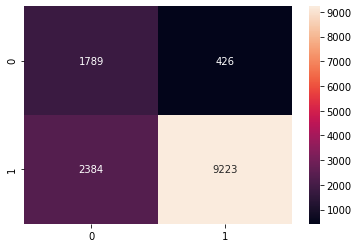

In [0]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test_avg, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test_avg, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test_avg, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test_avg, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test_avg, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 79.67%
Precision on test set: 95.59%
recall score on test set: 79.46%
f1 score on test set: 86.78%


### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 8</font>

In [22]:
X_train_tw, X_test_tw, y_train_tw, y_test_tw = train_test_split(np.array(tfidf_sent_vectors),final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train_tw = ss.fit_transform(X_train_tw)
X_test_tw = ss.transform(X_test_tw)

print(X_train_tw.shape)
print(X_test_tw.shape)

(32249, 50)
(13822, 50)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=1)

param = {'n_neighbors':np.arange(3,100,2)}
gs= GridSearchCV(knn,param,cv=5,verbose=5,scoring='roc_auc',n_jobs=-1,return_train_score=True)
gs.fit(X_train_tw,y_train_tw)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 52.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 131.9min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 206.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=5)

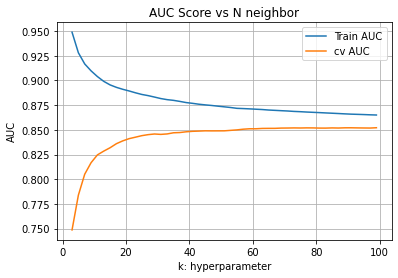

In [24]:
train_auc= gs.cv_results_['mean_train_score']
cv_auc = gs.cv_results_['mean_test_score'] 

plt.plot(param['n_neighbors'],train_auc,label='Train AUC')
plt.plot(param['n_neighbors'], cv_auc,label='cv AUC')
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title('AUC Score vs N neighbor')
plt.grid()
plt.legend()
plt.show()

In [25]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.
n=param['n_neighbors']
from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)

#if two local differnces are same then taking the one with less neighbor value
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_n=n[l[v]]
print(f'best n neighbor to use = {n[l[v]]}')

best cv score to use = 0.8520789294235463
best n neighbor to use = 91


In [0]:
knn = KNeighborsClassifier(n_neighbors=best_n, algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train_tw,y_train_tw)
y_pred_tw = knn.predict_proba(X_test_tw)
y_pred_tr = knn.predict_proba(X_train_tw)
y_pred_ts=y_pred_tw[:,1]
y_pred_tr = y_pred_tr[:,1]

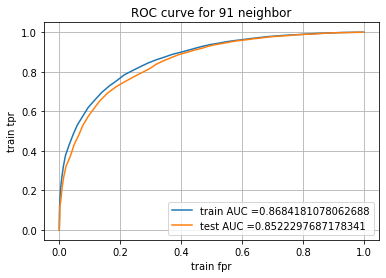

In [27]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_tw, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_tw, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("train fpr")
plt.ylabel("train tpr")
plt.title('ROC curve for '+str (best_n)+' neighbor')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented(10 times) is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [29]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.6169749530807316 for threshold 0.813


Train Confusion Matrix


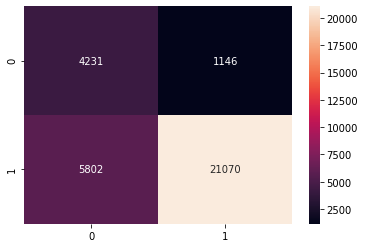

In [30]:
print('Train Confusion Matrix')
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_train_tw ,predict_with_best_t(y_pred_tr, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

Train Confusion Matrix


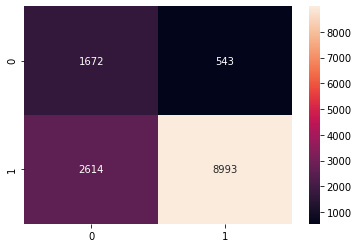

In [31]:
print('Train Confusion Matrix')
cm = pd.DataFrame(confusion_matrix(y_test_tw, predict_with_best_t(y_pred_ts, best_t)), range(2),range(2))
sns.heatmap(cm, annot=True,fmt='g')

In [32]:
acc=accuracy_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
ps=precision_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
rc=recall_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100
f1=f1_score(y_test_tw, predict_with_best_t(y_pred_ts, best_t))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 77.16%
Precision on test set: 94.31%
recall score on test set: 77.48%
f1 score on test set: 85.07%


# [6] Conclusions

In [35]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["S.NO.", "MODEL","Featurization", "Best K", "Test AUC","Precision-Score",'Accuracy',"F1-Score"]
x.add_row(["1", "brute force(10K)", "BOW","6863",'0.9025',"96.04%",'82.50%', "88.79%"])
x.add_row(["2", "brute force(100)", "BOW","45",'0.6408',"87.74%", '70.13%',"80.81%"])
x.add_row(["3", "brute force(10K)", "TFIDF","9860",'0.9207',"96.81%", '84.40%',"90.07%"])
x.add_row(["4", "brute force(100)", "TFIDF","35",'0.5211',"84.52%", '65.48%',"77.81%"])
x.add_row(["5", "brute force(100)", "AVG-W2V","97",'0.8822',"95.59%", '79.67%',"86.71%"])
x.add_row(["6", "brute force(100)", "TFIDF-W2V","91",'0.8522',"94.31%", '77.16%', "85.07%"])
x.add_row(["7", "KD-TREE(100)", "BOW","71",'0.7538',"92.12%", '68.48%',"78.44%"])
x.add_row(["8", "KD-TREE(100)", "TFIDF","37",'0.5965',"86.94%", '58.57%',"70.73%"])
x.add_row(["9", "KD-TREE(100)", "AVG-W2V","97",'0.8822',"95.59%", '79.67%',"86.78%"])
x.add_row(["10", "KD-TREE(100)", "TFIDF-W2V","91",'0.8522',"94.31%", '77.16%',"85.07%"])

print(x)

+-------+------------------+---------------+--------+----------+-----------------+----------+----------+
| S.NO. |      MODEL       | Featurization | Best K | Test AUC | Precision-Score | Accuracy | F1-Score |
+-------+------------------+---------------+--------+----------+-----------------+----------+----------+
|   1   | brute force(10K) |      BOW      |  6863  |  0.9025  |      96.04%     |  82.50%  |  88.79%  |
|   2   | brute force(100) |      BOW      |   45   |  0.6408  |      87.74%     |  70.13%  |  80.81%  |
|   3   | brute force(10K) |     TFIDF     |  9860  |  0.9207  |      96.81%     |  84.40%  |  90.07%  |
|   4   | brute force(100) |     TFIDF     |   35   |  0.5211  |      84.52%     |  65.48%  |  77.81%  |
|   5   | brute force(100) |    AVG-W2V    |   97   |  0.8822  |      95.59%     |  79.67%  |  86.71%  |
|   6   | brute force(100) |   TFIDF-W2V   |   91   |  0.8522  |      94.31%     |  77.16%  |  85.07%  |
|   7   |   KD-TREE(100)   |      BOW      |   71   |  

#### Three ROC graphs have been titled incorrectly regarding the n_neighbors used
1. ROC Curve for brute force BOW 100k that is number 2 graph has 6863 in title but should have had 45.
2.ROC Curve for brute force TFIDF 100k that is number 3 graph has 35 in title but should have had 9860.
3.ROC Curve for KD-Tree BOW 100 that is number 7 graph has 37 in title but should have had 71.


please note this occured due to jumbled cell running and only affects the title not the graph as graph used pickled data while best_n, the shared variable among cells got updated.